In [547]:
from keras.utils import image_dataset_from_directory
import os
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
import numpy as np
print( f"NumPy {np.__version__}\n" )
import matplotlib.pyplot as plt
from gradcam import get_img_array,make_gradcam_heatmap,save_and_display_gradcam
from show_predicted_img import show_predicted_img

TensorFlow 2.13.0
tf.keras.backend.image_data_format() = channels_last
NumPy 1.23.2



In [548]:
# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [549]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

In [550]:
PATH = 'dataset/train/'

In [551]:
train_ds = image_dataset_from_directory(
  PATH,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(224, 224))

print(train_ds.class_names)

Found 640 files belonging to 4 classes.


Using 576 files for training.
['caribou', 'deer', 'elk', 'moose']


In [552]:
val_ds = image_dataset_from_directory(
  PATH,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(224, 224))

print(train_ds.class_names)

Found 640 files belonging to 4 classes.
Using 64 files for validation.
['caribou', 'deer', 'elk', 'moose']


In [553]:
test_ds = image_dataset_from_directory(
  'dataset/test/',
  seed=123,
  image_size=(224, 224))

print(test_ds.class_names)

Found 160 files belonging to 4 classes.
['caribou', 'deer', 'elk', 'moose']


In [554]:
dataaug = tf.keras.models.Sequential( [
                                          tf.keras.Input(shape=(224,224,3)),
                                          tf.keras.layers.RandomFlip(mode='horizontal', name='rand_flip'),
                                          tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest', name='rand_trans'),
                                          tf.keras.layers.RandomRotation(factor=0.1, fill_mode='nearest', name='rand_rot'),
                                          tf.keras.layers.RandomZoom(height_factor=0.1,fill_mode='nearest'),
                                          tf.keras.layers.RandomBrightness(0.2),
                                          tf.keras.layers.Rescaling(1./255)
                                      ],
                                     name='dataaug' )

In [555]:
c = 0
for x,y in train_ds:
    # print(x.shape)
    # print(x)
    # print(y)
    c += len(x)
print(c)

576


In [556]:
augmented_train = train_ds.map(lambda x,y: (dataaug(x,training=True),y))

2023-11-01 11:51:15.962573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


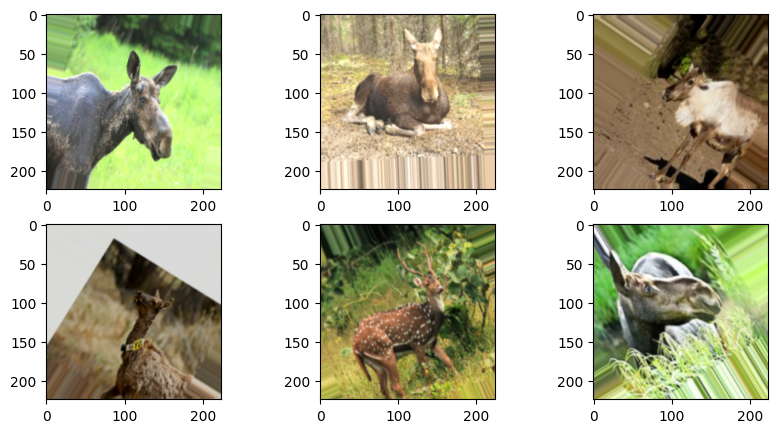

In [557]:
# show original vs resized
fig, ax = plt.subplots(2, 3, figsize=(10,5))
ax = ax.ravel()
for images, labels in augmented_train:
    for i in range(6):
        ax[i].imshow(images[i])

In [558]:
full_train_ds = train_ds.concatenate(augmented_train)

In [559]:
c = 0
for x,y in full_train_ds:
    c += len(x)
print(c)

2023-11-01 11:51:24.072990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1152


In [560]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = full_train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [561]:
def preprocess(images, labels):
  return preprocess_input(images), labels

train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [495]:
base_model = ResNet152V2(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")
base_model.trainable = False
# for layer in base_model.layers:
#     # if layer.name in ['conv5_block3_3_conv']:
#     #     layer.trainable = True
    # if "BatchNormalization" in layer.__class__.__name__:
    #     layer.trainable = True

In [496]:
# Fine-tune from this layer onwards
start_tune = 551
stop_tune = 561

# Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[start_tune:stop_tune]:
#   layer.trainable = True

for layer in base_model.layers:
  if layer.__class__.__name__ in ["BatchNormalization"]:
    layer.trainable = True

In [497]:
for i,layer in enumerate(base_model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_33 , trainable = False
Layer 1: name = conv1_pad , trainable = False
Layer 2: name = conv1_conv , trainable = False
Layer 3: name = pool1_pad , trainable = False
Layer 4: name = pool1_pool , trainable = False
Layer 5: name = conv2_block1_preact_bn , trainable = True
Layer 6: name = conv2_block1_preact_relu , trainable = False
Layer 7: name = conv2_block1_1_conv , trainable = False
Layer 8: name = conv2_block1_1_bn , trainable = True
Layer 9: name = conv2_block1_1_relu , trainable = False
Layer 10: name = conv2_block1_2_pad , trainable = False
Layer 11: name = conv2_block1_2_conv , trainable = False
Layer 12: name = conv2_block1_2_bn , trainable = True
Layer 13: name = conv2_block1_2_relu , trainable = False
Layer 14: name = conv2_block1_0_conv , trainable = False
Layer 15: name = conv2_block1_3_conv , trainable = False
Layer 16: name = conv2_block1_out , trainable = False
Layer 17: name = conv2_block2_preact_bn , trainable = True
Layer 18: name = conv2_block2_prea

In [498]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_33[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [499]:
# tf.keras.utils.plot_model(base_model, to_file='resnet_feature.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

In [500]:
base_model_output = base_model.output

x = tf.keras.layers.Flatten()(base_model_output)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model
model = tf.keras.models.Model(inputs=base_model.inputs, outputs=new_outputs)
model.summary()

Model: "model_56"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_33[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                           

In [501]:
for i,layer in enumerate(model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_33 , trainable = False
Layer 1: name = conv1_pad , trainable = False
Layer 2: name = conv1_conv , trainable = False
Layer 3: name = pool1_pad , trainable = False
Layer 4: name = pool1_pool , trainable = False
Layer 5: name = conv2_block1_preact_bn , trainable = True
Layer 6: name = conv2_block1_preact_relu , trainable = False
Layer 7: name = conv2_block1_1_conv , trainable = False
Layer 8: name = conv2_block1_1_bn , trainable = True
Layer 9: name = conv2_block1_1_relu , trainable = False
Layer 10: name = conv2_block1_2_pad , trainable = False
Layer 11: name = conv2_block1_2_conv , trainable = False
Layer 12: name = conv2_block1_2_bn , trainable = True
Layer 13: name = conv2_block1_2_relu , trainable = False
Layer 14: name = conv2_block1_0_conv , trainable = False
Layer 15: name = conv2_block1_3_conv , trainable = False
Layer 16: name = conv2_block1_out , trainable = False
Layer 17: name = conv2_block2_preact_bn , trainable = True
Layer 18: name = conv2_block2_prea

In [502]:
# Defining Callbacks

checkpoint_filepath = "resnet_callback/bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.h5"
early_stop_patience = 60
reduce_lr_patience = 20
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = early_stop_patience,
                              verbose = 1)

checkpoint    = ModelCheckpoint(checkpoint_filepath, 
                                monitor = 'val_loss', 
                                mode='min', 
                                save_best_only=True,
                                save_weights_only=False, 
                                verbose = 1,
                                option = tf.saved_model.SaveOptions)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=reduce_lr_patience, min_lr=0.00005,verbose=1)
callback_list = [earlystopping, checkpoint,reduce_lr]

In [503]:
# Model Compile 
lr = 0.0001
OPT    = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
# OPT    = tf.keras.optimizers.legacy.RMSprop(learning_rate=lr)
# OPT = tf.keras.optimizers.legacy.Adagrad(learning_rate=lr)

model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [504]:
epoch = 80
model_history=model.fit(train_dataset,
                        validation_data=validation_dataset,
                        epochs = epoch,
                        callbacks = callback_list,
                        verbose = 2)

Epoch 1/80


2023-11-01 09:56:28.092524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-01 09:58:51.595920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-01 09:59:44.097639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 2.55440, saving model to resnet_callback/bestmodel_epoch01_valloss2.55.h5


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 - 250s - loss: 1.6328 - accuracy: 0.4905 - val_loss: 2.5544 - val_accuracy: 0.6562 - lr: 1.0000e-04 - 250s/epoch - 7s/step
Epoch 2/80


2023-11-01 10:00:44.078703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 2: val_loss improved from 2.55440 to 0.89930, saving model to resnet_callback/bestmodel_epoch02_valloss0.90.h5
36/36 - 42s - loss: 0.9898 - accuracy: 0.6710 - val_loss: 0.8993 - val_accuracy: 0.8281 - lr: 1.0000e-04 - 42s/epoch - 1s/step
Epoch 3/80


2023-11-01 10:01:24.355134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 3: val_loss improved from 0.89930 to 0.86075, saving model to resnet_callback/bestmodel_epoch03_valloss0.86.h5
36/36 - 41s - loss: 0.8902 - accuracy: 0.7075 - val_loss: 0.8608 - val_accuracy: 0.7812 - lr: 1.0000e-04 - 41s/epoch - 1s/step
Epoch 4/80


2023-11-01 10:02:05.363310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 4: val_loss improved from 0.86075 to 0.41743, saving model to resnet_callback/bestmodel_epoch04_valloss0.42.h5
36/36 - 39s - loss: 0.8470 - accuracy: 0.7335 - val_loss: 0.4174 - val_accuracy: 0.8281 - lr: 1.0000e-04 - 39s/epoch - 1s/step
Epoch 5/80


2023-11-01 10:02:44.576394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 5: val_loss did not improve from 0.41743
36/36 - 40s - loss: 0.7351 - accuracy: 0.7396 - val_loss: 0.5797 - val_accuracy: 0.8281 - lr: 1.0000e-04 - 40s/epoch - 1s/step
Epoch 6/80


2023-11-01 10:03:23.590831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 6: val_loss did not improve from 0.41743
36/36 - 36s - loss: 0.7086 - accuracy: 0.7483 - val_loss: 0.4594 - val_accuracy: 0.7969 - lr: 1.0000e-04 - 36s/epoch - 1s/step
Epoch 7/80


2023-11-01 10:04:00.778928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 7: val_loss did not improve from 0.41743
36/36 - 40s - loss: 0.7199 - accuracy: 0.7457 - val_loss: 0.5711 - val_accuracy: 0.8125 - lr: 1.0000e-04 - 40s/epoch - 1s/step
Epoch 8/80


2023-11-01 10:04:39.648938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 8: val_loss did not improve from 0.41743
36/36 - 38s - loss: 0.6885 - accuracy: 0.7665 - val_loss: 0.5279 - val_accuracy: 0.7969 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 9/80


2023-11-01 10:05:18.113437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 9: val_loss did not improve from 0.41743
36/36 - 38s - loss: 0.6961 - accuracy: 0.7743 - val_loss: 0.5163 - val_accuracy: 0.8125 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 10/80


2023-11-01 10:05:55.584627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 10: val_loss did not improve from 0.41743
36/36 - 37s - loss: 0.6832 - accuracy: 0.7595 - val_loss: 0.4796 - val_accuracy: 0.8125 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 11/80


2023-11-01 10:06:32.659147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 11: val_loss did not improve from 0.41743
36/36 - 37s - loss: 0.6355 - accuracy: 0.7891 - val_loss: 0.4906 - val_accuracy: 0.8281 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 12/80


2023-11-01 10:07:10.511110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 12: val_loss did not improve from 0.41743
36/36 - 37s - loss: 0.5812 - accuracy: 0.8056 - val_loss: 0.4716 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 13/80


2023-11-01 10:07:47.229906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 13: val_loss improved from 0.41743 to 0.38371, saving model to resnet_callback/bestmodel_epoch13_valloss0.38.h5
36/36 - 39s - loss: 0.5843 - accuracy: 0.7995 - val_loss: 0.3837 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 39s/epoch - 1s/step
Epoch 14/80


2023-11-01 10:08:25.389309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 14: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.5620 - accuracy: 0.8073 - val_loss: 0.5387 - val_accuracy: 0.7969 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 15/80


2023-11-01 10:09:02.960162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 15: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.5620 - accuracy: 0.8056 - val_loss: 0.6312 - val_accuracy: 0.7969 - lr: 1.0000e-04 - 36s/epoch - 998ms/step
Epoch 16/80


2023-11-01 10:09:38.827285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 16: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.5722 - accuracy: 0.8003 - val_loss: 0.5194 - val_accuracy: 0.7812 - lr: 1.0000e-04 - 36s/epoch - 1s/step
Epoch 17/80


2023-11-01 10:10:15.024654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 17: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.5726 - accuracy: 0.7969 - val_loss: 0.5536 - val_accuracy: 0.8281 - lr: 1.0000e-04 - 36s/epoch - 994ms/step
Epoch 18/80


2023-11-01 10:10:50.916961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 18: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.5889 - accuracy: 0.7986 - val_loss: 0.4787 - val_accuracy: 0.8281 - lr: 1.0000e-04 - 36s/epoch - 1s/step
Epoch 19/80


2023-11-01 10:11:26.939339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 19: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.5202 - accuracy: 0.8177 - val_loss: 0.5111 - val_accuracy: 0.7812 - lr: 1.0000e-04 - 36s/epoch - 1s/step
Epoch 20/80


2023-11-01 10:12:03.417803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 20: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.5287 - accuracy: 0.8177 - val_loss: 0.5843 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 21/80


2023-11-01 10:12:41.007210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 21: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.4963 - accuracy: 0.8290 - val_loss: 0.5260 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 22/80


2023-11-01 10:13:17.392434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 22: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.4836 - accuracy: 0.8273 - val_loss: 0.4710 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 23/80


2023-11-01 10:14:04.886423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 23: val_loss did not improve from 0.38371
36/36 - 50s - loss: 0.4889 - accuracy: 0.8333 - val_loss: 0.4993 - val_accuracy: 0.8125 - lr: 1.0000e-04 - 50s/epoch - 1s/step
Epoch 24/80


2023-11-01 10:14:44.563145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 24: val_loss did not improve from 0.38371
36/36 - 41s - loss: 0.5018 - accuracy: 0.8238 - val_loss: 0.4861 - val_accuracy: 0.8281 - lr: 1.0000e-04 - 41s/epoch - 1s/step
Epoch 25/80


2023-11-01 10:15:28.530551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 25: val_loss did not improve from 0.38371
36/36 - 39s - loss: 0.5215 - accuracy: 0.8325 - val_loss: 0.5315 - val_accuracy: 0.8281 - lr: 1.0000e-04 - 39s/epoch - 1s/step
Epoch 26/80


2023-11-01 10:16:04.945424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 26: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.4966 - accuracy: 0.8307 - val_loss: 0.4692 - val_accuracy: 0.8125 - lr: 1.0000e-04 - 36s/epoch - 1s/step
Epoch 27/80


2023-11-01 10:16:41.280617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 27: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.4918 - accuracy: 0.8325 - val_loss: 0.4556 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 28/80


2023-11-01 10:17:17.552480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 28: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.5050 - accuracy: 0.8333 - val_loss: 0.5369 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 36s/epoch - 1s/step
Epoch 29/80


2023-11-01 10:17:54.840065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 29: val_loss did not improve from 0.38371
36/36 - 38s - loss: 0.4544 - accuracy: 0.8281 - val_loss: 0.6173 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 30/80


2023-11-01 10:18:31.089980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 30: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.4866 - accuracy: 0.8229 - val_loss: 0.5391 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 31/80


2023-11-01 10:19:07.638723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 31: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.4614 - accuracy: 0.8342 - val_loss: 0.5085 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 36s/epoch - 991ms/step
Epoch 32/80


2023-11-01 10:19:43.250259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 32: val_loss did not improve from 0.38371
36/36 - 35s - loss: 0.4250 - accuracy: 0.8438 - val_loss: 0.6183 - val_accuracy: 0.8281 - lr: 1.0000e-04 - 35s/epoch - 985ms/step
Epoch 33/80


2023-11-01 10:20:18.827022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 33: val_loss did not improve from 0.38371

Epoch 33: ReduceLROnPlateau reducing learning rate to 5e-05.
36/36 - 36s - loss: 0.4145 - accuracy: 0.8585 - val_loss: 0.5504 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 36s/epoch - 998ms/step
Epoch 34/80


2023-11-01 10:20:54.429517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 34: val_loss did not improve from 0.38371
36/36 - 35s - loss: 0.4155 - accuracy: 0.8403 - val_loss: 0.4861 - val_accuracy: 0.8281 - lr: 5.0000e-05 - 35s/epoch - 972ms/step
Epoch 35/80


2023-11-01 10:21:29.641463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 35: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.4329 - accuracy: 0.8455 - val_loss: 0.4514 - val_accuracy: 0.8438 - lr: 5.0000e-05 - 36s/epoch - 997ms/step
Epoch 36/80


2023-11-01 10:22:05.901731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 36: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.4435 - accuracy: 0.8446 - val_loss: 0.5000 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 36s/epoch - 1s/step
Epoch 37/80


2023-11-01 10:22:42.283442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 37: val_loss did not improve from 0.38371
36/36 - 40s - loss: 0.4082 - accuracy: 0.8481 - val_loss: 0.5181 - val_accuracy: 0.8438 - lr: 5.0000e-05 - 40s/epoch - 1s/step
Epoch 38/80


2023-11-01 10:23:22.413850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 38: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.4333 - accuracy: 0.8481 - val_loss: 0.5604 - val_accuracy: 0.8438 - lr: 5.0000e-05 - 37s/epoch - 1s/step
Epoch 39/80


2023-11-01 10:23:58.892397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 39: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.4229 - accuracy: 0.8394 - val_loss: 0.5254 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 36s/epoch - 1s/step
Epoch 40/80


2023-11-01 10:24:35.458450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 40: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.3741 - accuracy: 0.8490 - val_loss: 0.5283 - val_accuracy: 0.8438 - lr: 5.0000e-05 - 37s/epoch - 1s/step
Epoch 41/80


2023-11-01 10:25:13.375182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 41: val_loss did not improve from 0.38371
36/36 - 38s - loss: 0.4261 - accuracy: 0.8438 - val_loss: 0.5631 - val_accuracy: 0.8281 - lr: 5.0000e-05 - 38s/epoch - 1s/step
Epoch 42/80


2023-11-01 10:25:50.152686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 42: val_loss did not improve from 0.38371
36/36 - 35s - loss: 0.4247 - accuracy: 0.8533 - val_loss: 0.5719 - val_accuracy: 0.8438 - lr: 5.0000e-05 - 35s/epoch - 981ms/step
Epoch 43/80


2023-11-01 10:26:25.627435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 43: val_loss did not improve from 0.38371
36/36 - 42s - loss: 0.3823 - accuracy: 0.8655 - val_loss: 0.5737 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 42s/epoch - 1s/step
Epoch 44/80


2023-11-01 10:27:09.706565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 44: val_loss did not improve from 0.38371
36/36 - 39s - loss: 0.3794 - accuracy: 0.8793 - val_loss: 0.5669 - val_accuracy: 0.8438 - lr: 5.0000e-05 - 39s/epoch - 1s/step
Epoch 45/80


2023-11-01 10:27:48.844286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 45: val_loss did not improve from 0.38371
36/36 - 38s - loss: 0.3495 - accuracy: 0.8724 - val_loss: 0.5696 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 38s/epoch - 1s/step
Epoch 46/80


2023-11-01 10:28:25.794809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 46: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.3645 - accuracy: 0.8655 - val_loss: 0.5185 - val_accuracy: 0.8281 - lr: 5.0000e-05 - 37s/epoch - 1s/step
Epoch 47/80


2023-11-01 10:29:03.726456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 47: val_loss did not improve from 0.38371
36/36 - 38s - loss: 0.3670 - accuracy: 0.8689 - val_loss: 0.4818 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 38s/epoch - 1s/step
Epoch 48/80


2023-11-01 10:29:41.610141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 48: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.3664 - accuracy: 0.8628 - val_loss: 0.5128 - val_accuracy: 0.8281 - lr: 5.0000e-05 - 37s/epoch - 1s/step
Epoch 49/80


2023-11-01 10:30:18.147011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 49: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.3534 - accuracy: 0.8759 - val_loss: 0.5184 - val_accuracy: 0.8281 - lr: 5.0000e-05 - 36s/epoch - 998ms/step
Epoch 50/80


2023-11-01 10:30:54.020391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 50: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.3656 - accuracy: 0.8568 - val_loss: 0.5749 - val_accuracy: 0.8281 - lr: 5.0000e-05 - 37s/epoch - 1s/step
Epoch 51/80


2023-11-01 10:31:30.939157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 51: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.3636 - accuracy: 0.8646 - val_loss: 0.5606 - val_accuracy: 0.8125 - lr: 5.0000e-05 - 36s/epoch - 1s/step
Epoch 52/80


2023-11-01 10:32:06.913280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 52: val_loss did not improve from 0.38371
36/36 - 35s - loss: 0.3733 - accuracy: 0.8681 - val_loss: 0.5180 - val_accuracy: 0.8125 - lr: 5.0000e-05 - 35s/epoch - 982ms/step
Epoch 53/80


2023-11-01 10:32:42.116391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 53: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.3346 - accuracy: 0.8663 - val_loss: 0.4890 - val_accuracy: 0.8281 - lr: 5.0000e-05 - 36s/epoch - 994ms/step
Epoch 54/80


2023-11-01 10:33:18.148503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 54: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.3546 - accuracy: 0.8707 - val_loss: 0.5022 - val_accuracy: 0.8125 - lr: 5.0000e-05 - 36s/epoch - 1s/step
Epoch 55/80


2023-11-01 10:33:54.677967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 55: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.3810 - accuracy: 0.8594 - val_loss: 0.5865 - val_accuracy: 0.8125 - lr: 5.0000e-05 - 37s/epoch - 1s/step
Epoch 56/80


2023-11-01 10:34:31.468091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 56: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.3788 - accuracy: 0.8715 - val_loss: 0.6187 - val_accuracy: 0.7812 - lr: 5.0000e-05 - 37s/epoch - 1s/step
Epoch 57/80


2023-11-01 10:35:08.701576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 57: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.3829 - accuracy: 0.8646 - val_loss: 0.5994 - val_accuracy: 0.8125 - lr: 5.0000e-05 - 37s/epoch - 1s/step
Epoch 58/80


2023-11-01 10:35:45.584191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 58: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.3873 - accuracy: 0.8663 - val_loss: 0.6176 - val_accuracy: 0.7969 - lr: 5.0000e-05 - 36s/epoch - 999ms/step
Epoch 59/80


2023-11-01 10:36:22.004924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 59: val_loss did not improve from 0.38371
36/36 - 41s - loss: 0.3451 - accuracy: 0.8819 - val_loss: 0.5343 - val_accuracy: 0.7656 - lr: 5.0000e-05 - 41s/epoch - 1s/step
Epoch 60/80


2023-11-01 10:37:05.284713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 60: val_loss did not improve from 0.38371
36/36 - 42s - loss: 0.3401 - accuracy: 0.8759 - val_loss: 0.4899 - val_accuracy: 0.8438 - lr: 5.0000e-05 - 42s/epoch - 1s/step
Epoch 61/80


2023-11-01 10:37:47.630997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 61: val_loss did not improve from 0.38371
36/36 - 39s - loss: 0.3449 - accuracy: 0.8724 - val_loss: 0.5127 - val_accuracy: 0.7969 - lr: 5.0000e-05 - 39s/epoch - 1s/step
Epoch 62/80


2023-11-01 10:38:23.801396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 62: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.3360 - accuracy: 0.8767 - val_loss: 0.5142 - val_accuracy: 0.8125 - lr: 5.0000e-05 - 36s/epoch - 993ms/step
Epoch 63/80


2023-11-01 10:38:59.387677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 63: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.3550 - accuracy: 0.8655 - val_loss: 0.5441 - val_accuracy: 0.8125 - lr: 5.0000e-05 - 36s/epoch - 996ms/step
Epoch 64/80


2023-11-01 10:39:35.368413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 64: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.3405 - accuracy: 0.8715 - val_loss: 0.5883 - val_accuracy: 0.7969 - lr: 5.0000e-05 - 36s/epoch - 1s/step
Epoch 65/80


2023-11-01 10:40:12.398329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 65: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.3271 - accuracy: 0.8811 - val_loss: 0.5523 - val_accuracy: 0.8125 - lr: 5.0000e-05 - 37s/epoch - 1s/step
Epoch 66/80


2023-11-01 10:40:49.518668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 66: val_loss did not improve from 0.38371
36/36 - 42s - loss: 0.3320 - accuracy: 0.8741 - val_loss: 0.6283 - val_accuracy: 0.7969 - lr: 5.0000e-05 - 42s/epoch - 1s/step
Epoch 67/80


2023-11-01 10:41:31.681324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 67: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.3339 - accuracy: 0.8750 - val_loss: 0.5852 - val_accuracy: 0.8281 - lr: 5.0000e-05 - 37s/epoch - 1s/step
Epoch 68/80


2023-11-01 10:42:07.708581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 68: val_loss did not improve from 0.38371
36/36 - 35s - loss: 0.3346 - accuracy: 0.8819 - val_loss: 0.5297 - val_accuracy: 0.8281 - lr: 5.0000e-05 - 35s/epoch - 986ms/step
Epoch 69/80


2023-11-01 10:42:43.267330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 69: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.3209 - accuracy: 0.8837 - val_loss: 0.5576 - val_accuracy: 0.8281 - lr: 5.0000e-05 - 37s/epoch - 1s/step
Epoch 70/80


2023-11-01 10:43:20.059887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 70: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.3541 - accuracy: 0.8637 - val_loss: 0.5750 - val_accuracy: 0.8281 - lr: 5.0000e-05 - 37s/epoch - 1s/step
Epoch 71/80


2023-11-01 10:43:56.681454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 71: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.3322 - accuracy: 0.8759 - val_loss: 0.6055 - val_accuracy: 0.7656 - lr: 5.0000e-05 - 36s/epoch - 991ms/step
Epoch 72/80


2023-11-01 10:44:32.438372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 72: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.3113 - accuracy: 0.8741 - val_loss: 0.5520 - val_accuracy: 0.7969 - lr: 5.0000e-05 - 36s/epoch - 1s/step
Epoch 73/80


2023-11-01 10:45:09.060494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 73: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.3321 - accuracy: 0.8715 - val_loss: 0.6169 - val_accuracy: 0.7969 - lr: 5.0000e-05 - 36s/epoch - 997ms/step
Epoch 74/80


2023-11-01 10:45:44.967876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 74: val_loss did not improve from 0.38371
36/36 - 35s - loss: 0.3518 - accuracy: 0.8741 - val_loss: 0.6383 - val_accuracy: 0.7969 - lr: 5.0000e-05 - 35s/epoch - 977ms/step
Epoch 75/80


2023-11-01 10:46:19.808628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 75: val_loss did not improve from 0.38371
36/36 - 35s - loss: 0.3507 - accuracy: 0.8689 - val_loss: 0.6157 - val_accuracy: 0.7656 - lr: 5.0000e-05 - 35s/epoch - 961ms/step
Epoch 76/80


2023-11-01 10:46:54.520277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 76: val_loss did not improve from 0.38371
36/36 - 35s - loss: 0.3398 - accuracy: 0.8672 - val_loss: 0.5899 - val_accuracy: 0.7969 - lr: 5.0000e-05 - 35s/epoch - 967ms/step
Epoch 77/80


2023-11-01 10:47:29.374576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 77: val_loss did not improve from 0.38371
36/36 - 35s - loss: 0.3344 - accuracy: 0.8663 - val_loss: 0.5669 - val_accuracy: 0.8281 - lr: 5.0000e-05 - 35s/epoch - 972ms/step
Epoch 78/80


2023-11-01 10:48:04.818717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 78: val_loss did not improve from 0.38371
36/36 - 37s - loss: 0.3272 - accuracy: 0.8663 - val_loss: 0.6161 - val_accuracy: 0.8125 - lr: 5.0000e-05 - 37s/epoch - 1s/step
Epoch 79/80


2023-11-01 10:48:41.628184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 79: val_loss did not improve from 0.38371
36/36 - 36s - loss: 0.3468 - accuracy: 0.8724 - val_loss: 0.5875 - val_accuracy: 0.8125 - lr: 5.0000e-05 - 36s/epoch - 1s/step
Epoch 80/80


2023-11-01 10:49:17.564662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 80: val_loss did not improve from 0.38371
36/36 - 35s - loss: 0.3129 - accuracy: 0.8785 - val_loss: 0.6307 - val_accuracy: 0.7969 - lr: 5.0000e-05 - 35s/epoch - 984ms/step


In [520]:
history = model_history.history

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

Text(0, 0.5, 'Accuracy')

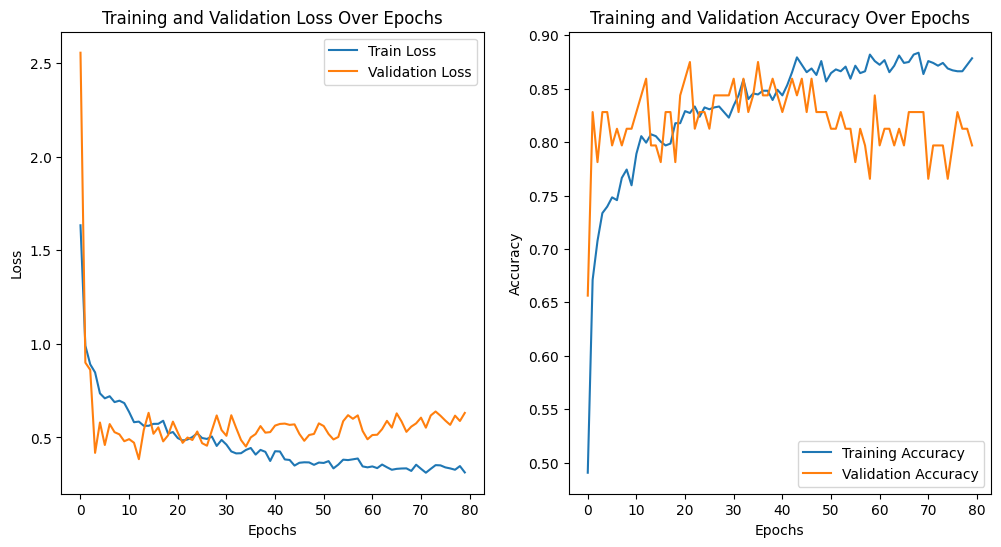

In [521]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(train_loss,label='Train Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [562]:
test_result = model.evaluate(test_dataset)
print(f'{model.metrics_names}: {test_result}')

2023-11-01 11:51:42.561335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 52s 2s/step - loss: 0.7704 - accuracy: 0.7437
['loss', 'accuracy']: [0.770420253276825, 0.7437499761581421]


In [563]:
model_path = "resnet_callback/train_batch_norm_bestmodel_maxpool_epoch07_valloss0.47.h5"
loaded_model = tf.keras.models.load_model(model_path)
results = loaded_model.evaluate(test_dataset)
print(f'{loaded_model.metrics_names}: {results}')

2023-11-01 11:52:44.326919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 46s 1s/step - loss: 0.7560 - accuracy: 0.7875
['loss', 'accuracy']: [0.7559600472450256, 0.7875000238418579]


In [564]:
model_path = "resnet_callback/train_batch_norm_bestmodel_nopool_epoch04_valloss0.44.h5"
loaded_model = tf.keras.models.load_model(model_path)
results = loaded_model.evaluate(test_dataset)
print(f'{loaded_model.metrics_names}: {results}')

2023-11-01 11:53:37.056377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 72s 2s/step - loss: 0.8563 - accuracy: 0.7563
['loss', 'accuracy']: [0.8563203811645508, 0.7562500238418579]


In [565]:
model_path = "resnet_callback/train_batch_norm_bestmodel_nopool_epoch05_valloss0.36.h5"
loaded_model = tf.keras.models.load_model(model_path)
results = loaded_model.evaluate(test_dataset)
print(f'{loaded_model.metrics_names}: {results}')

2023-11-01 11:55:02.607162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 60s 2s/step - loss: 0.6427 - accuracy: 0.7750
['loss', 'accuracy']: [0.6427484750747681, 0.7749999761581421]


In [566]:
model_path = "resnet_callback/train_batch_norm_bestmodel_nopool_epoch13_valloss0.38.h5"
loaded_model = tf.keras.models.load_model(model_path)
results = loaded_model.evaluate(test_dataset)
print(f'{loaded_model.metrics_names}: {results}')

2023-11-01 11:56:03.105083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 61s 1s/step - loss: 0.5821 - accuracy: 0.8062
['loss', 'accuracy']: [0.5821494460105896, 0.8062499761581421]


In [567]:
results = loaded_model.evaluate(train_dataset)
print(f'{loaded_model.metrics_names}: {results}')

 8/36 [=====>........................] - ETA: 44s - loss: 0.1447 - accuracy: 0.9492

2023-11-01 11:57:25.216431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 24s 611ms/step - loss: 0.8690 - accuracy: 0.5998
['loss', 'accuracy']: [0.8690165281295776, 0.5998263955116272]


In [568]:
results = loaded_model.evaluate(validation_dataset)
print(f'{loaded_model.metrics_names}: {results}')

2/2 [==============================] - 1s 335ms/step - loss: 0.3837 - accuracy: 0.8594
['loss', 'accuracy']: [0.38370612263679504, 0.859375]


In [579]:
loaded_model.summary()

Model: "model_56"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_33[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                           

In [570]:
last_conv_layer_name = "conv5_block3_out"

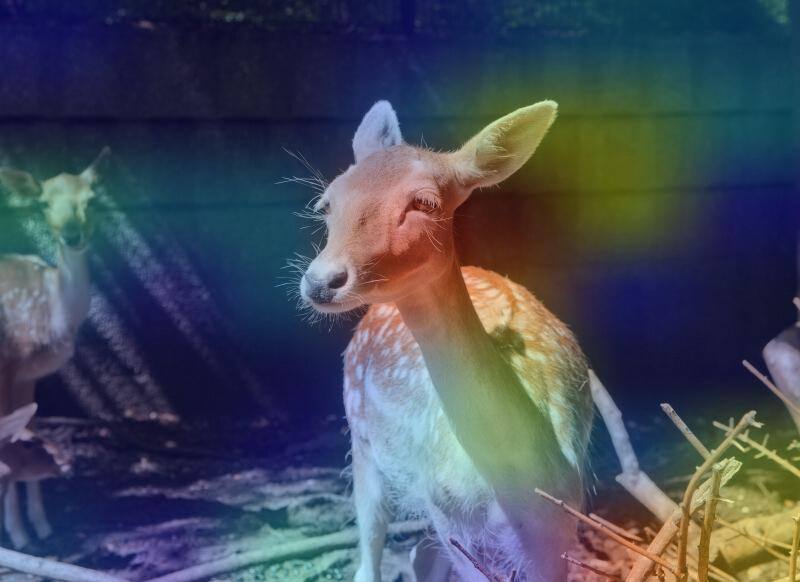

In [571]:
grad_cam_img_path = 'dataset/train/deer/fallow_deer_4.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)
save_and_display_gradcam(grad_cam_img_path, heatmap)

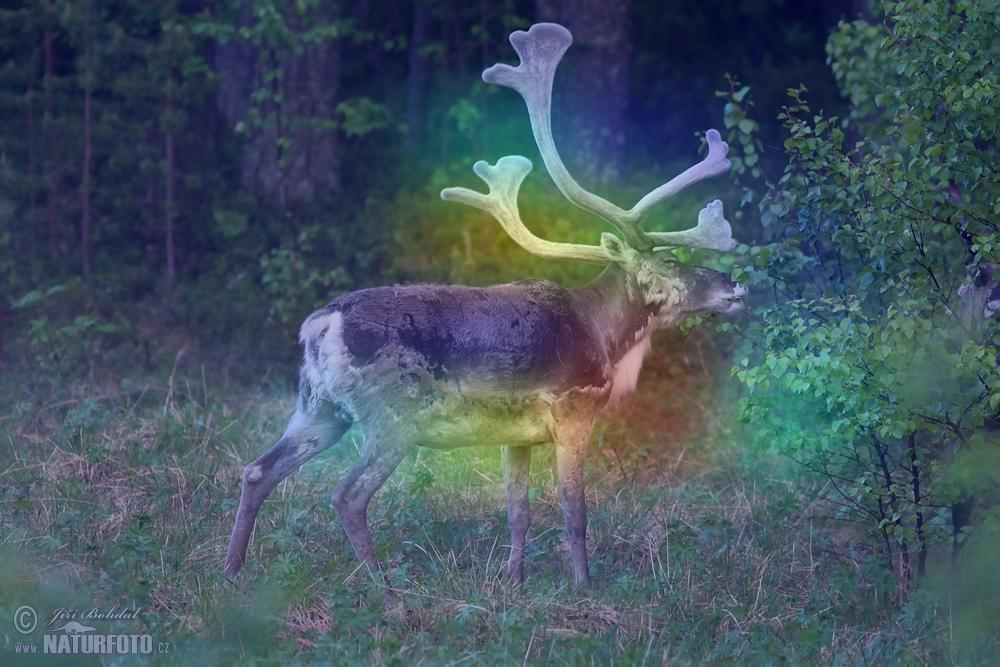

In [572]:
grad_cam_img_path = 'dataset/train/caribou/Male_Caribou56.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)
save_and_display_gradcam(grad_cam_img_path, heatmap)

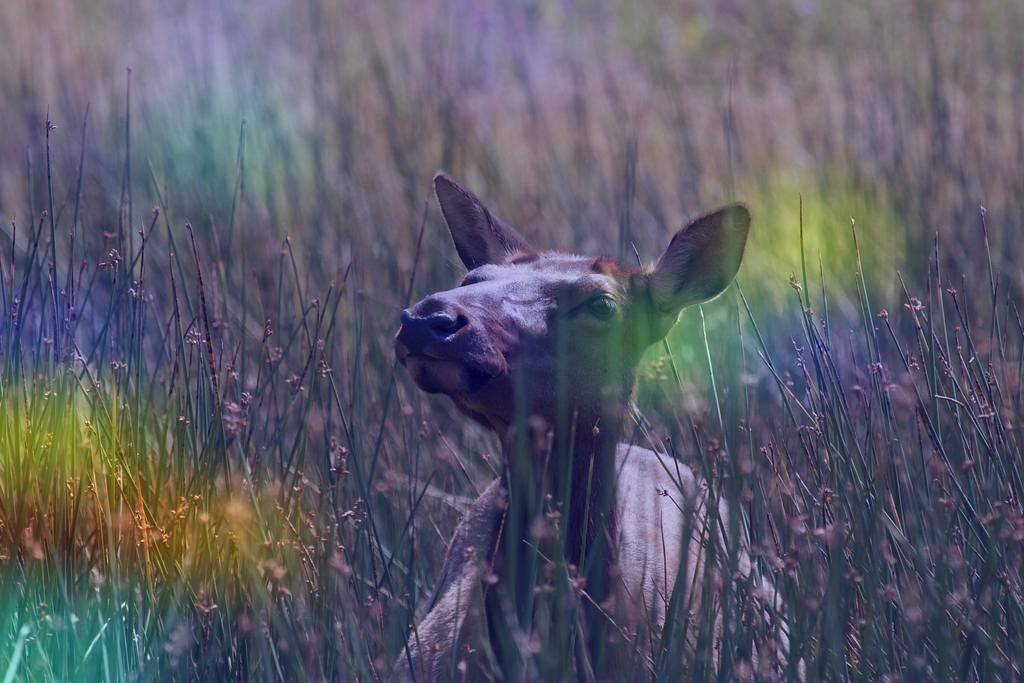

In [573]:
grad_cam_img_path = 'dataset/train/elk/EDF9.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

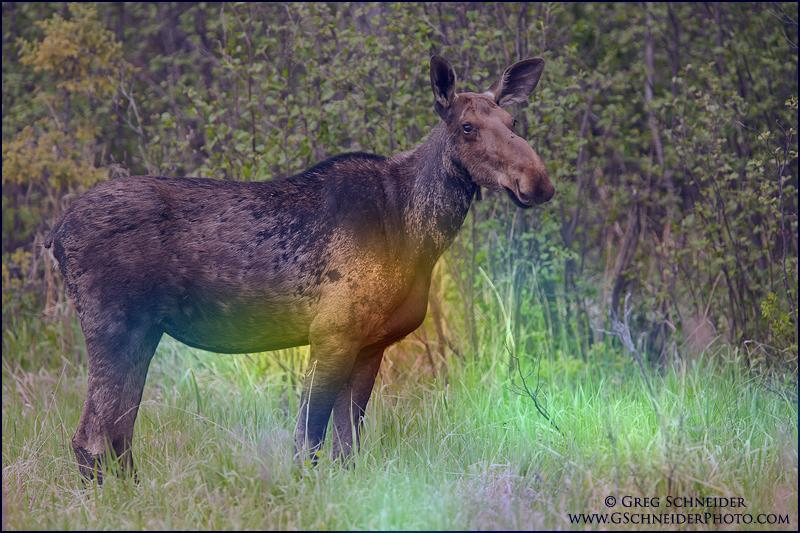

In [574]:

grad_cam_img_path = 'dataset/train/moose/female_moose (23).jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

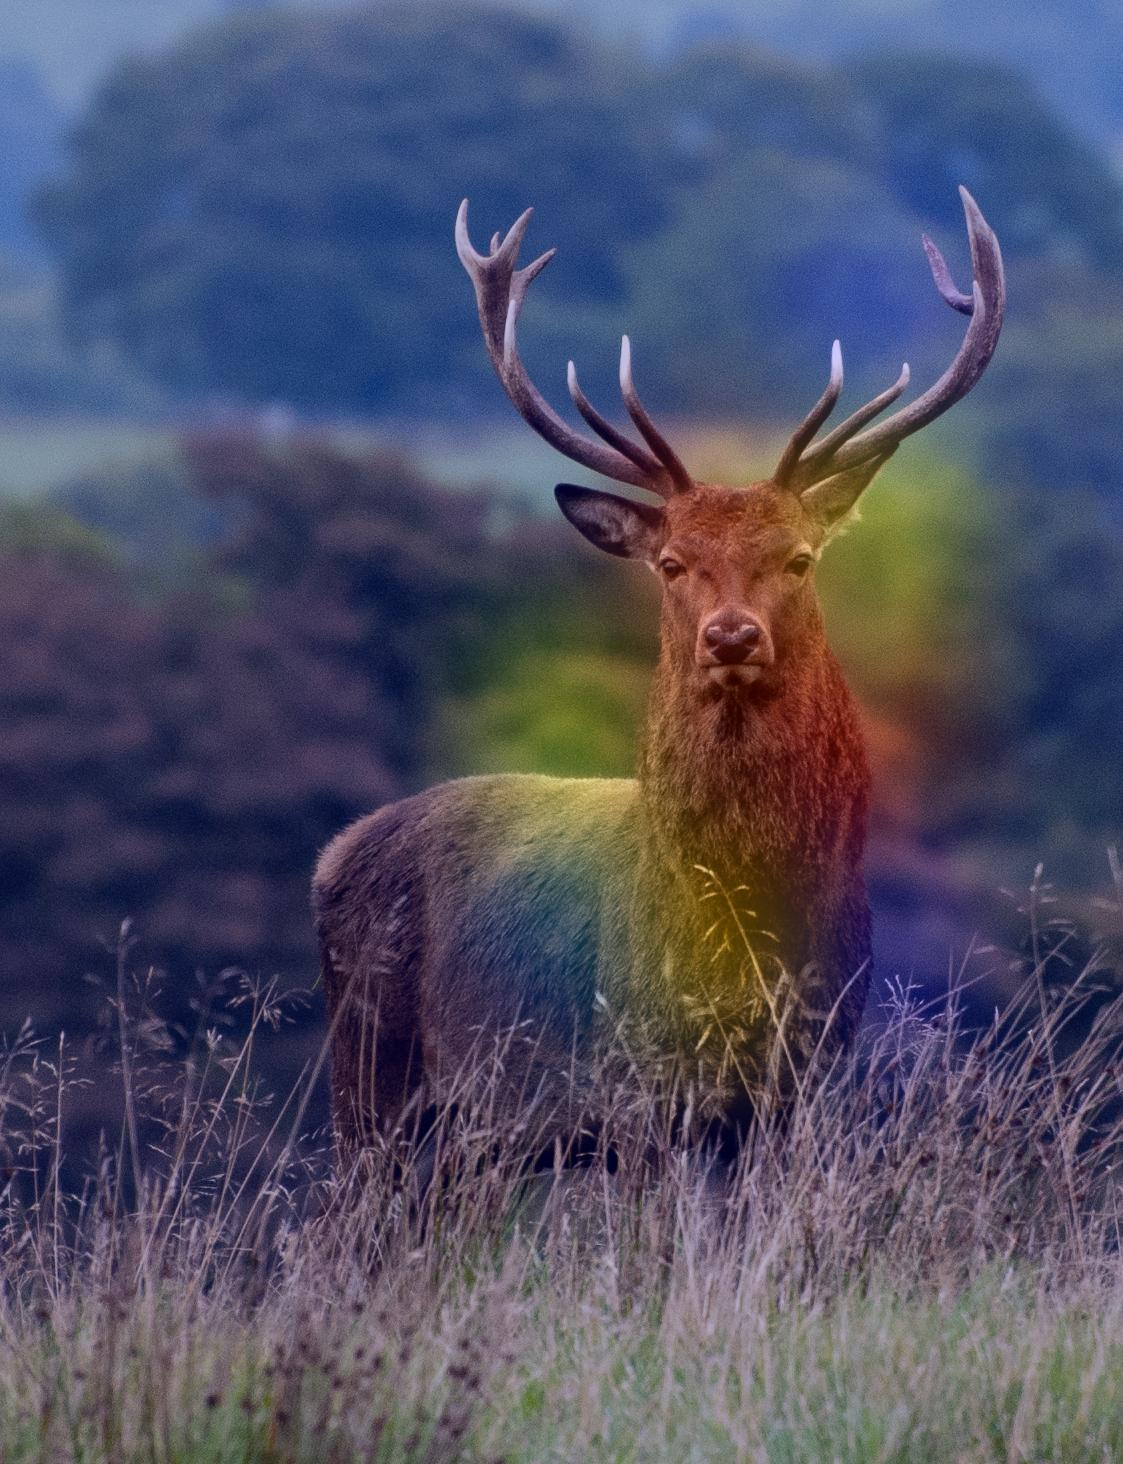

In [575]:
grad_cam_img_path = 'dataset/test/deer/red_deer_00044.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

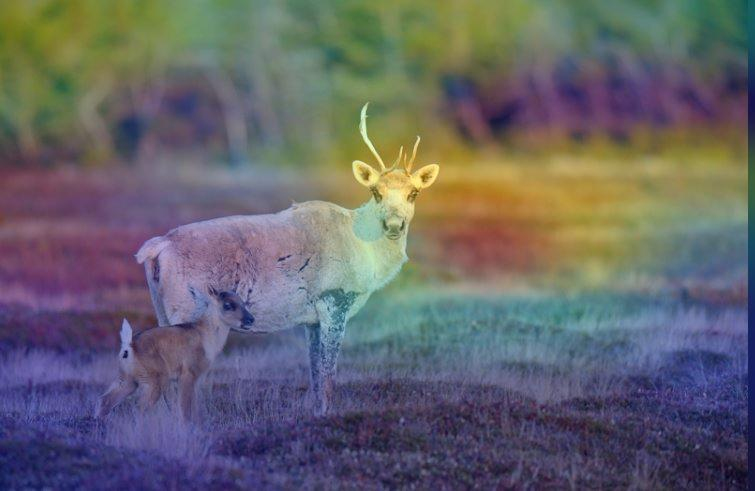

In [576]:
grad_cam_img_path = 'dataset/train/caribou/Female_Caribou91.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

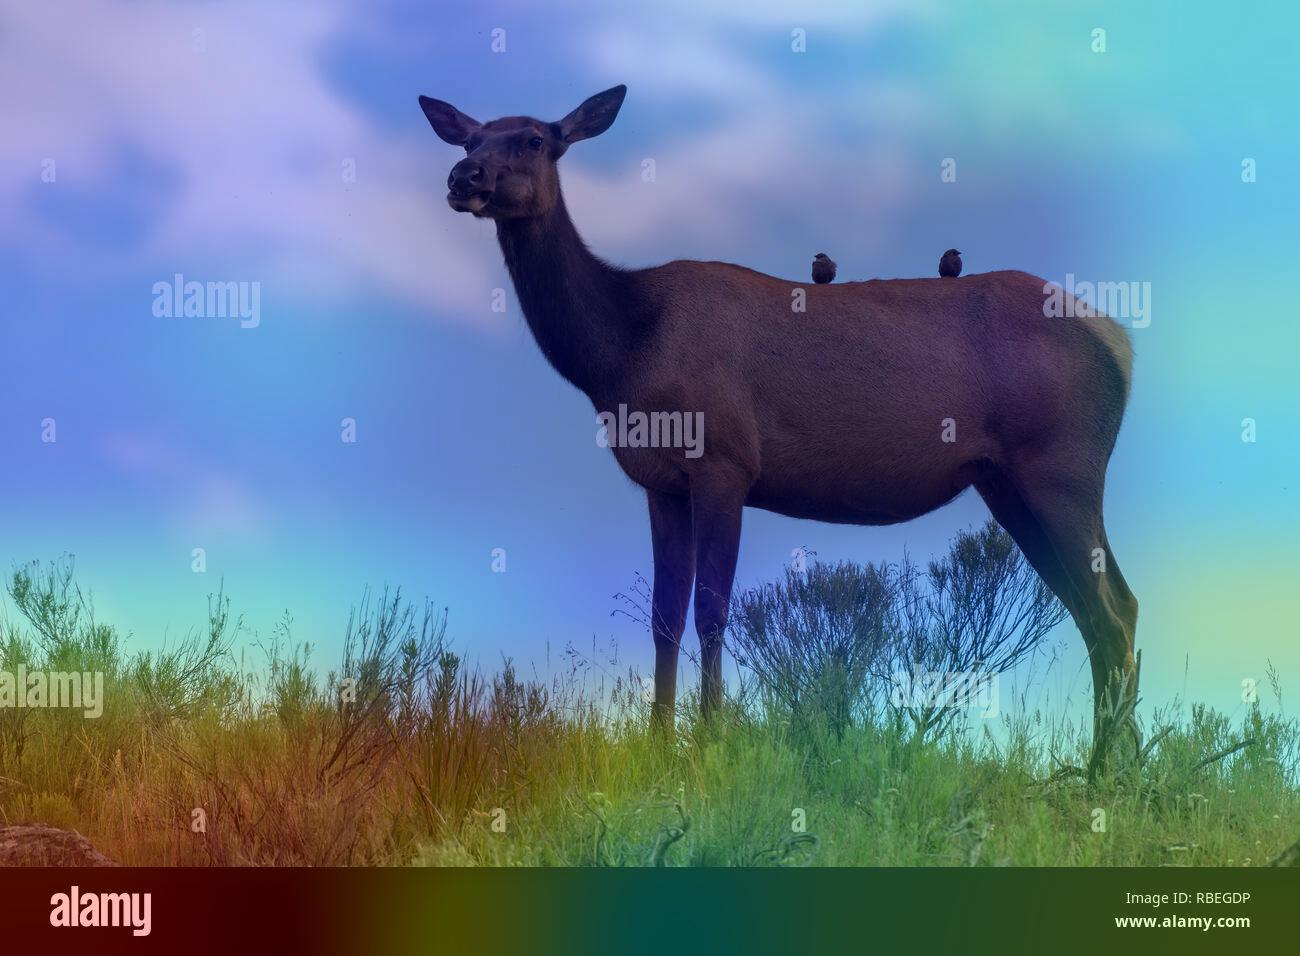

In [577]:
grad_cam_img_path = 'dataset/train/elk/EDF78.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

2023-11-01 12:00:40.299495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 56s 56s/step


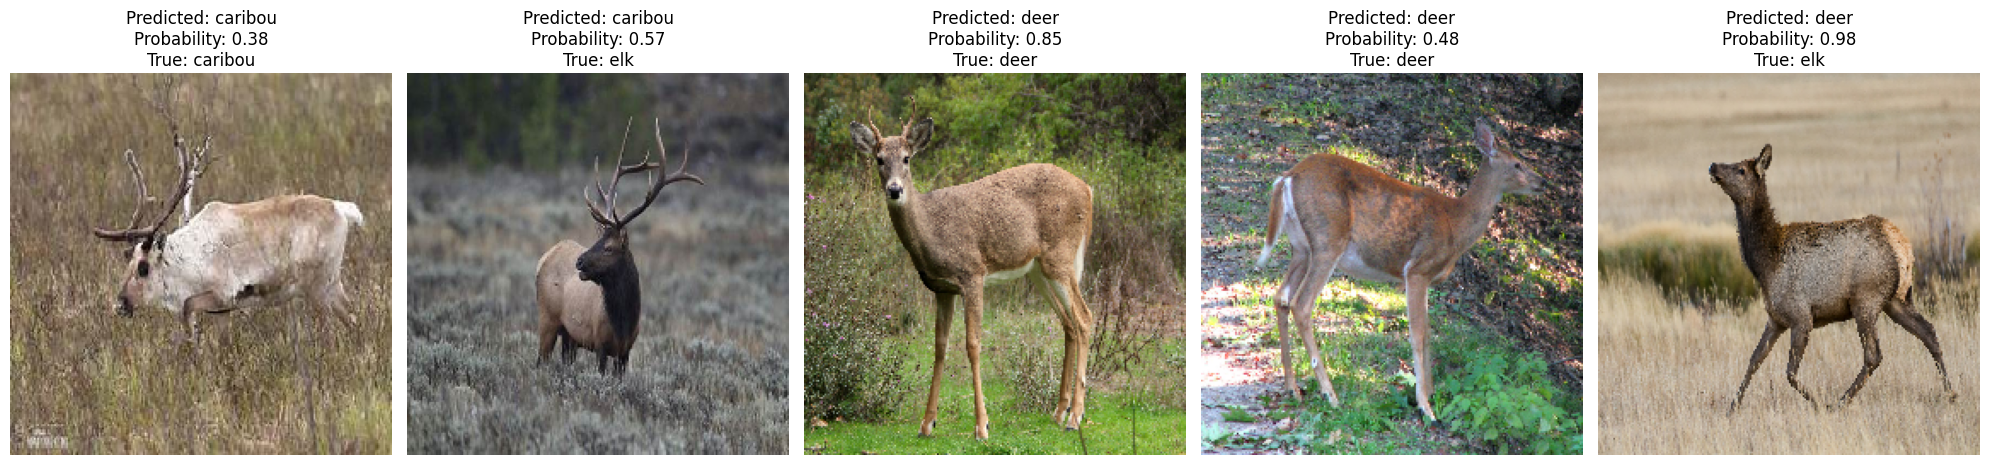

In [578]:
test_images_directory = 'dataset/test/'
class_name = {0:'caribou',1:'deer',2:'elk',3:'moose'}
show_predicted_img(loaded_model,test_images_directory,class_name)